# Using Autoencoder architecture to create latent representation of 1024 time domain scans

## Proposed Approaches
1. Classic Classification on encoder-decoder latent vector  
- Train encoder-decoder on reconstruction task  
- Train FCNN to classify the pulses  

2. Hybrid network approach  
- Multi-headed network to produce latent space and classify from the latent space  
- Creates a classification focussed embedding  
- Joint loss function (will need loss contributions to be tuned)  

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import MSELoss

from torch.utils.data import DataLoader, TensorDataset
from models.Encoder_decoder import Autoencoder,train_autoencoder
from models.utils import identify_device, load_thz_dataset
from Simulate import simulate_reference

from models.encoder_decoder_utils import plot_latent_space, plot_latent_space_with_labels


# Load THz pulse dataset (assumes each sample is a 1D tensor of size 1024)
data = torch.load("Synthetic_data_60k.pt", weights_only=False)
synthetic_data = data["synthetic_data"]  # [N, 1024]
num_layers = data["num_layers"]

synthetic_data.shape

torch.Size([60000, 1024])

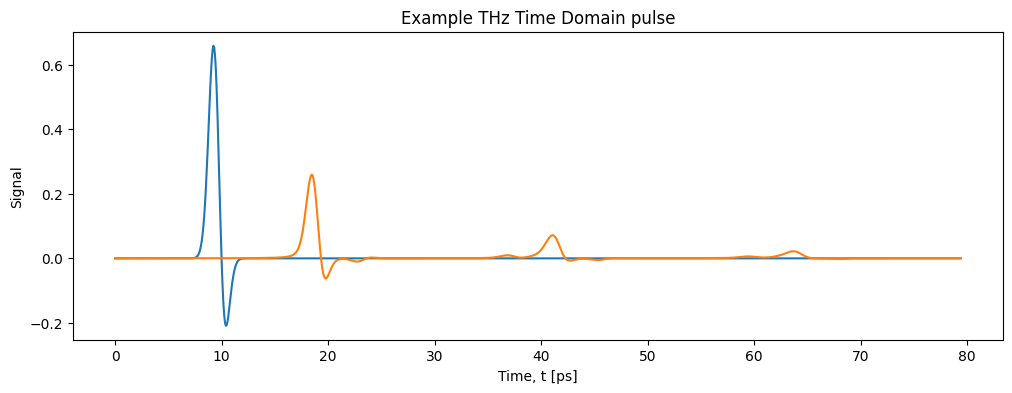

In [2]:
deltat = 0.0194e-12 * 4 # 4x multiple from the downsampling during dataset production
L = synthetic_data.shape[1]
t_axis = np.arange(0, L*deltat, deltat)


ref_pulse = simulate_reference(L=4*L, deltat=deltat)[:L].detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.title('Example THz Time Domain pulse')
plt.plot(t_axis*1e12, ref_pulse)
plt.plot(t_axis*1e12, synthetic_data[0])
plt.ylabel('Signal')
plt.xlabel('Time, t [ps]')
plt.show()

Using device: mps


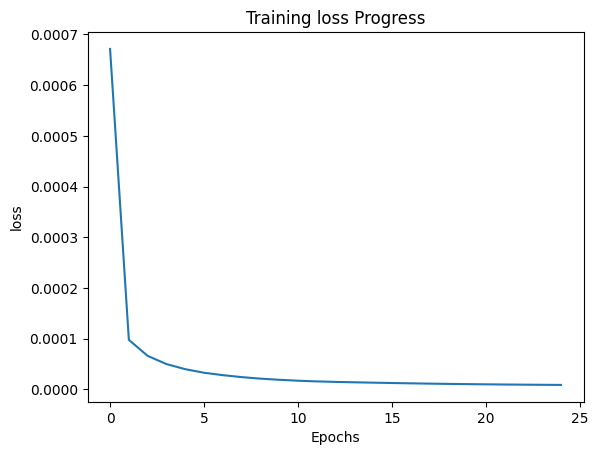

In [3]:
# Create DataLoader
dataset = TensorDataset(synthetic_data)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Model + training
model = Autoencoder(input_dim=1024, latent_dim=32)
device = identify_device()
loss = train_autoencoder(model, loader, device, num_epochs=25, lr=1e-4, verbose='batch')


# Plot the accuracy values
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training loss Progress')
plt.show()

Sample Index: 37071
Loss between signals: 1.2371781394904247e-06


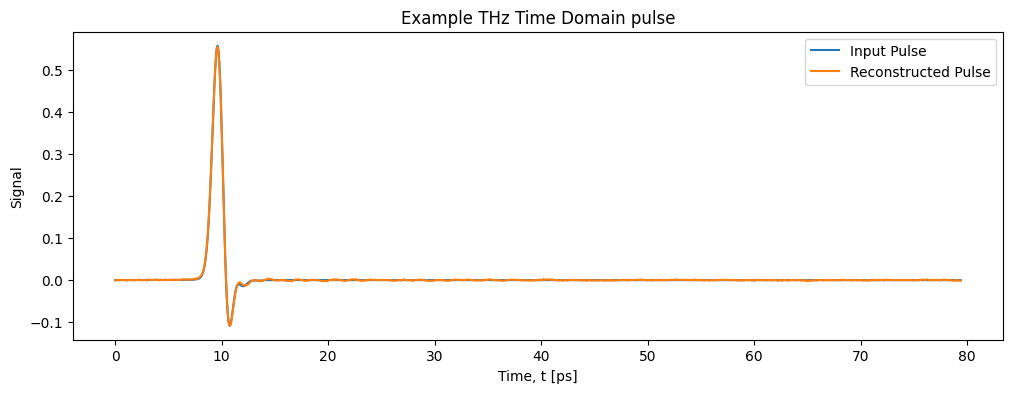

In [4]:
sample_index = np.random.randint(0, len(synthetic_data))

print(f'Sample Index: {sample_index}')

def test_model(index):
    real_pulse = synthetic_data[index]  
    input_pulse = real_pulse.to(device)#.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        recon_pulse = model(input_pulse)

    # Bring both to CPU and remove batch dim if added
    recon_pulse_cpu = recon_pulse.squeeze(0).cpu()
    real_pulse_cpu = real_pulse.cpu()


    criterion = MSELoss()
    loss = criterion(recon_pulse_cpu, real_pulse_cpu).item()
    print(f'Loss between signals: {loss}')

    # Convert to NumPy for plotting
    recon_np = recon_pulse_cpu.numpy()
    real_np = real_pulse_cpu.numpy()

    plt.figure(figsize=(12,4))
    plt.title('Example THz Time Domain pulse')
    plt.plot(t_axis*1e12, real_np, label='Input Pulse')
    plt.plot(t_axis*1e12, recon_np, label='Reconstructed Pulse')
    plt.ylabel('Signal')
    plt.xlabel('Time, t [ps]')
    plt.legend()
    plt.show()

test_model(sample_index)

Loss between signals: 4.401570913614705e-05


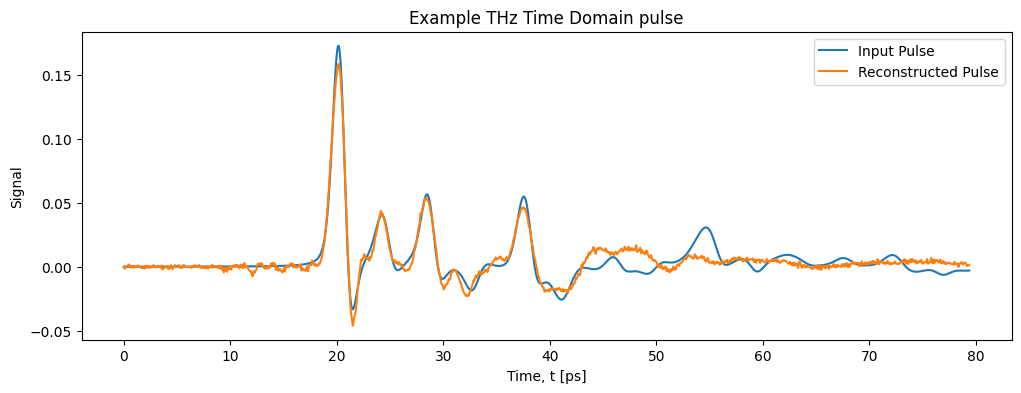

In [5]:
## NOTE: sample index: 41212  needs checking
# Example of weak loss contributor due to low overall amplitude


test_model(41212)

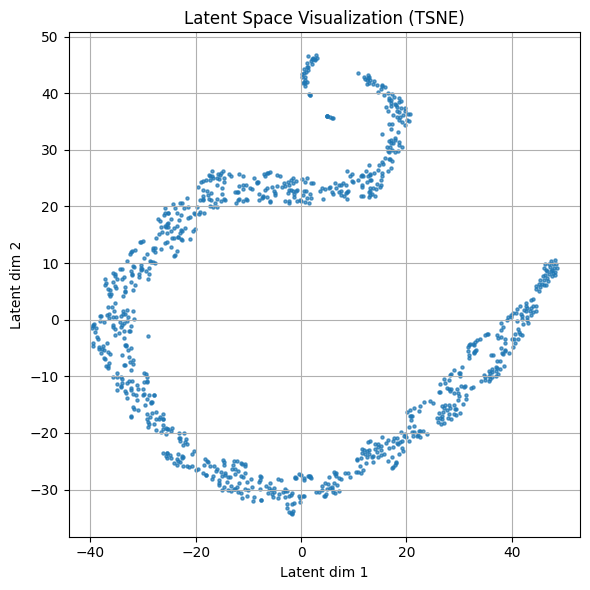

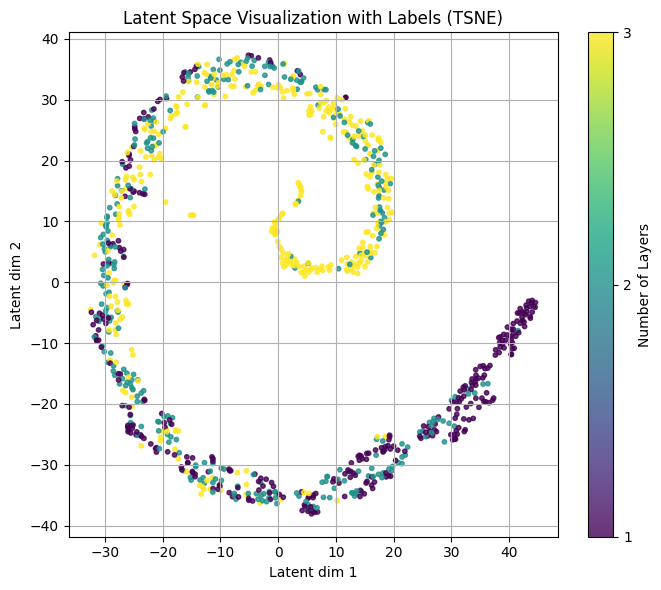

In [17]:
plot_latent_space_with_labels(model, synthetic_data, num_layers, device, 'tsne', 1000)